In [1]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import nibabel as nib
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow_io as tfio
import radiomics
from radiomics import featureextractor,firstorder

In [2]:
#data https://wiki.cancerimagingarchive.net/display/Public/Lung+CT+Segmentation+Challenge+2017

In [5]:
# function return a mean feature of a single image
def GetMean(data):

    return np.mean(data.reshape(len(data[0])**2))

    
# ddd = np.array([[[1],[2],[3]],[[3],[2],[1]],[[2],[2],[2]]])
# ddd.shape
# print(GetMean(ddd))

In [6]:



# load data files
def Load_data_dicts(foldernames):
    result = []
    for i in foldernames:
        files  = tf.io.gfile.listdir('./Lung_Train/' + i)
        for j in files:
            result.append(tf.io.read_file('./Lung_Train/'+ i +'/' + j))
    return result

image_bytes = Load_data_dicts(['d1','d2', 'd3', 'd4','d5','d6','d7','d8','d9','d10','d11','d12'])


print(np.array(image_bytes).shape)
# files = tf.io.gfile.listdir('./Lung_Train/d1')
# files2 = tf.io.gfile.listdir('./Lung_Train/d2')
filestest = Load_data_dicts(['t1'])

(1736,)


In [7]:
# load the image data 
# image_bytes=[]
# image_bytestest = []
# for i in files:
#     image_bytes.append(tf.io.read_file('./Lung_Train/d1/'+ i))
# for i in files2:
#     image_bytes.append(tf.io.read_file('./Lung_Train/d2/'+ i))
    
    
    
# for i in filestest:
#     image_bytestest.append(tf.io.read_file('./Lung_Train/t1/'+ i))

In [9]:
#scale it to unit8
images = []
imagestest = []
for i in image_bytes:
    image = tfio.image.decode_dicom_image(i, color_dim=True,scale='auto',on_error='lossy', dtype=tf.uint8)[0]
    images.append(image)
    
for i in filestest:
    imagetest = tfio.image.decode_dicom_image(i, color_dim=True,scale='auto',on_error='lossy', dtype=tf.uint8)[0]
    imagestest.append(imagetest)

In [10]:
images = np.array(images)
imagestest = np.array(imagestest)
#imagestest = np.array(imagesval)
images.shape
imagestest.shape

(130, 512, 512, 1)

In [11]:
# output_mean image data
output_mean_image = []
output_mean_imagetest = []
for i in images:
    output_mean_image.append(GetMean(i))
    
for i in imagestest:
    output_mean_imagetest.append(GetMean(i))
    
output_mean_image= np.array(output_mean_image)

output_mean_imagetest= np.array(output_mean_imagetest)
# output_mean_imagetest.shape

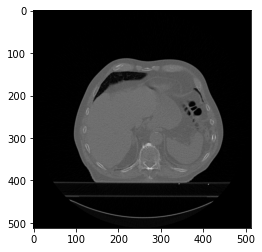

In [13]:
plt.imshow(np.squeeze(image.numpy()), cmap='gray')

In [14]:
input_layer = keras.Input(shape=(512,512,1))
x = Flatten()(input_layer)
mean_1 = Dense(128, activation='relu')(x)
mean_2 = Dense(128, activation='relu')(mean_1)
mean_3 = Dense(128, activation='relu')(mean_2)
mean_4 = Dense(128, activation='relu')(mean_3)
mean_5 = Dense(128, activation='relu')(mean_4)
mean_out = Dense(1, activation = 'linear', name = 'mean')(mean_5)

meanModel = keras.Model(input_layer, mean_out, name= "mean")

In [18]:
meanModel.compile(optimizer=tf.keras.optimizers.Adam(
    lr= 0.000001
), loss="mean_squared_error")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

In [20]:
meanModel.fit(images, output_mean_image, 
             # validation_data=(imagesval,output_mean_imageval), 
              epochs=1000, batch_size=32,
             #callbacks=[es],
                shuffle=True)


Epoch 1/1000
55/55 [==============================] - 5s 83ms/step - loss: 0.0269
Epoch 2/1000
55/55 [==============================] - 5s 82ms/step - loss: 0.0302
Epoch 3/1000
 5/55 [=>............................] - ETA: 4s - loss: 0.0190

KeyboardInterrupt: 

5/5 [==============================] - 0s 15ms/step


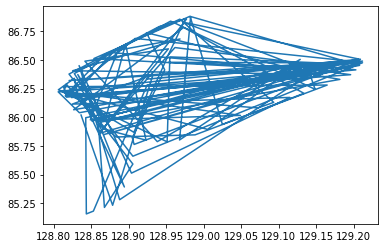

In [26]:
#plt.plot(range(30),output_mean_imagetest[:30] ,range(30),meanModel.predict(imagestest)[:30] )
plt.plot(output_mean_imagetest ,meanModel.predict(imagestest) )
#meanModel.predict(imagestest).shape
#output_mean_imagetest.shape

In [197]:
#extractor = featureextractor.RadiomicsFeatureExtractor()
#extractor.execute('./Lung_Train/1-001.dcm','./Lung_Train/1-001.dcm')

In [27]:
meanModel.save(("./radiomics_mean.h5"))